# 06-04 - Community Detection with Flow Compression

*June 3 2024*  

We conclude this week's practice lecture by showing how we can use the compression of random walks to detect communities.

In [10]:
import pathpyG as pp
import numpy as np

from tqdm import tqdm_notebook as tqdm
import seaborn as sns

from collections import defaultdict
from matplotlib import pyplot as plt

We create the example network shown in the lecture:

In [11]:
edges = []
for i in range(4):
    for v in range(i*4, i*4+4):
        for w in range(i*4, i*4+4):
            if v != w and (str(v),str(w)) not in edges:
                edges.append((str(v), str(w)))

edges.append(('2', '4'))
edges.append(('6', '8'))
edges.append(('10', '12'))
edges.append(('14', '0'))

g = pp.Graph.from_edge_list(edges)
g=g.to_undirected()
pp.plot(g, node_label = [g.mapping.to_id(i) for i in range(g.N)])

In the previous notebook, we used Huffman coding to calculate the length of the compressed sequence. Rather than actually compressing the sequence, we can use Shannon's source coding theorem to calculate a lower bound for the per-symbol code length of the compressed sequence.

Building on the MapEquation, we can implement a function that computes the *minimal code or description length* for a **particular** sequence of nodes visited by a random walker and a given assignment of nodes to communities. For this, we adapt the MapEquation to calculate the minimum description length of a given walk sequence (e.g. a list of nodes) based on the observed number of switches between communities and between nodes within different communities in the walk sequence.

We reuse the functions implemented in the previous unit:

In [12]:
def log2_0(x):
    if x==0:
        return 0
    else:
        return np.log2(x)
    
def minimal_code_length(p, module_map):
    # create reverse mapping from modules to nodes
    module_to_nodes = defaultdict(list)
    for node in module_map:
        module_to_nodes[module_map[node]].append(node)

    module_labels = set(module_map.values())

    # number of all transitions
    transitions = len(p)-1

    # transitions within a module, for all modules
    within_prob = defaultdict(lambda: 0.0)

    # transitions that exit a module, for all modules
    exit_prob = defaultdict(lambda: 0.0)

    # transitions through all nodes
    node_prob = defaultdict(lambda: 0.0)

    
    # look up module of first node and set as current_module
    current_module = module_map[p[0]]
    node_prob[p[0]] += 1

    #we write the first community label in the first 
    exit_prob[current_module] += 1

    # for each transition ... 
    for x in p[1:]:
        # ... count number of transitions through node x
        node_prob[x] += 1

        # ... count transition within module 
        if module_map[x] == current_module:
            within_prob[current_module] += 1
        else: # or count exit transition
            exit_prob[current_module] += 1                      
            # and update current module
            current_module = module_map[x]
    
    # calculate exit and within community probabilities for all modules
    for i in module_labels:
        exit_prob[i] = exit_prob[i] / (transitions +1)
        within_prob[i] = within_prob[i] / transitions

    q = 0.0
    for i in module_labels:
        q += exit_prob[i]
    
    S = 0.0
    H_Q = 0.0
    
    for n in module_map.keys():
        node_prob[n] = node_prob[n] / (transitions+1)

    # sum entropies for within-module transitions across modules
    for m in module_labels:
        
        D = 0.0
        for w in module_to_nodes[m]:
            D += node_prob[w]
        H_Q += -D*log2_0(D)
        
        H_Pi = 0
        for w in module_to_nodes[m]:
            x = -(node_prob[w]/D)
            y = (log2_0(node_prob[w]/D))
            H_Pi+= x*y
        S += D * H_Pi
    
    #print (q, "*", -H_Q, "+", -S)
    
    return (q * H_Q + S)

We test our function in the toy example from the lecture. We use the specific random walk sequence from the lecture to calculate the minimal code length for (i) the correct community partition, (ii) an underfitted model, and (iii) an overfitted model. We additionally create a node to cluster mapping such that the walk changes between clusters in each step.

In [3]:
walk = "0,1,2,3,1,0,3,2,4,5,6,7,4,5,7,6,8,9,10,11,9,8,11,10,12,13,14,15,13,12,14,15".split(",")

We create the 'correct' node to community mapping for this network. We also create modules that underfit, overfit and that are completely opposite to the cluster structure in this toy network.

In [4]:
m_true = {}
for i in range(16):
    m_true[str(i)] = i//4

m_underfit = {}
for i in range(16):
    m_underfit[str(i)] = i//8

m_overfit = {}
for i in range(16):
    m_overfit[str(i)] = i//2

m_flipped = {}
for i in range(16):
    m_flipped[str(i)] = i%4

In [8]:
print('Codelength of walk  = {0} bits'.format(32*minimal_code_length(walk, m_true)))
print('Codelength per step = {0} bits'.format(minimal_code_length(walk, m_true)))
colors = sns.color_palette("Set1", 200).as_hex()
node_colors = []

for v in g.nodes:
    node_colors.append(colors[m_true[v]])
pp.plot(g, node_color = node_colors, edge_color='grey')

Codelength of walk  = 72.0 bits
Codelength per step = 2.25 bits


In [9]:
print('Codelength of walk  = {0} bits'.format(32*minimal_code_length(walk, m_overfit)))
print('Codelength per step = {0} bits'.format(minimal_code_length(walk, m_overfit)))


node_colors = []

for v in g.nodes:
    node_colors.append(colors[m_overfit[v]])
pp.plot(g, node_color = node_colors, edge_color='grey')

Codelength of walk  = 80.0 bits
Codelength per step = 2.5 bits


In [11]:
print('Codelength of walk   = {0} bits'.format(32*minimal_code_length(walk, m_underfit)))
print('Codelength per step  = {0} bits'.format(minimal_code_length(walk, m_underfit)))

node_colors = []

for v in g.nodes:
    node_colors.append(colors[m_underfit[v]])
pp.plot(g, node_color = node_colors, edge_color='grey');

Codelength of walk   = 98.0 bits
Codelength per step  = 3.0625 bits


In [12]:
print('Codelength of walk  = {0} bits'.format(32*minimal_code_length(walk, m_flipped)))
print('Codelength per step = {0} bits'.format(minimal_code_length(walk, m_flipped)))

node_colors = []

for v in g.nodes:
    node_colors.append(colors[m_flipped[v]])
pp.plot(g, node_color = node_colors, edge_color='grey');

Codelength of walk  = 128.0 bits
Codelength per step = 4.0 bits


We now implement a simple greedy algorithm that finds the community assignments that best compress a specific sequence of nodes traversed by a random walk:

In [23]:
def merge(C, x, y):
    D = {}
    for i in C:
        if C[i] == x:
            D[i] = y
        else:
            D[i] = C[i]
    return D

def find_communities_walk(network, walk, iterations=100):
    
    # we start with each node being in a separate cluster
    C = {}
    c = 0
    for n in network.nodes:
        C[n] = c
        c += 1
    
    dl = minimal_code_length(walk, C)
    communities = set(C.values())
    dl_vals = [dl]
    
    for i in range(iterations):
        # randomly choose two communities
        if len(communities)>1:
            ind = np.random.choice(len(walk)-2)
            x, y = C[walk[ind]], C[walk[ind+1]]
            
            # check description length of merged communities
            dl_new = minimal_code_length(walk, merge(C,x,y))
            if dl_new < dl:
                # merge the communities
                C = merge(C, x, y)
                communities=set(C.values())
                dl = dl_new
            dl_vals.append(dl)
    return C, dl_vals

We can generate a sequence of nodes using the RandomWalk class in `pathpy`. We then use this function to detect communities that best compress this sequence. We also show the decrease of the description length as we merge more and more communities:

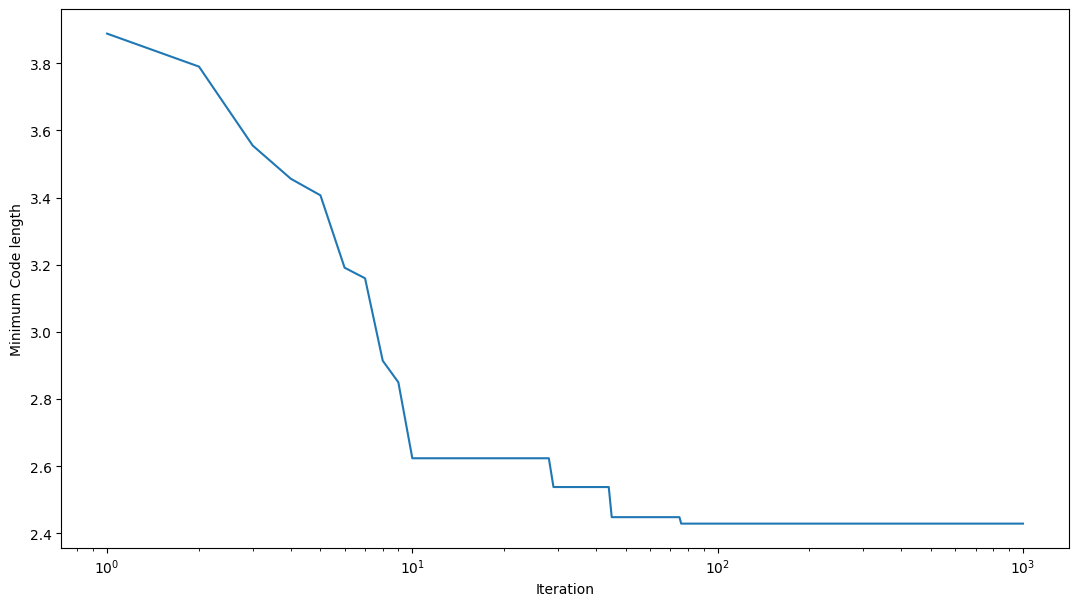

In [19]:
rw = pp.processes.RandomWalk(g)
walk = []
for t, v in rw.simulation_run(steps=1000):
    walk.append(v[0])

C, dl = find_communities_walk(g, walk, iterations=1000)

plt.figure(figsize=(13,7))
plt.semilogx([i for i in range(1,len(dl)+1)], dl)
plt.xlabel("Iteration")
plt.ylabel("Minimum Code length")
plt.show()

We finally visualize the detected community structures in our example network

In [13]:
colors = sns.color_palette("Set1", 200).as_hex()

node_colors = []
for v in g.nodes:
    node_colors.append(colors[C[v]])
pp.plot(g, node_color = node_colors, edge_color='grey');

NameError: name 'C' is not defined

We now apply this method to the empirical Karate club network.

In [34]:
n_karate = pp.io.netzschleuder.read_netzschleuder_network('karate', '77')


In [22]:
print(n_karate)

Undirected graph with 34 nodes and 154 (directed) edges

Node attributes
	node__pos		<class 'list'>
	node_name		<class 'list'>
	node_groups		<class 'list'>

Graph attributes
	citation		<class 'str'>
	tags		<class 'list'>
	url		<class 'str'>
	name		<class 'str'>
	num_nodes		<class 'int'>
	description		<class 'str'>



In [23]:
#reverse_index = {v:k for k, v in n_karate.nodes.index.items()}
ground_truth = [n_karate.data.node_groups[i][0]-1 for i in range(n_karate.N)]

colors = sns.color_palette("Set1", 50).as_hex()

node_colors = []
groups = n_karate.data.node_groups
for v in n_karate.nodes:
    node_colors.append(colors[groups[n_karate.mapping.to_idx(v)][0]])
pp.plot(n_karate, node_color = node_colors, edge_color='grey');

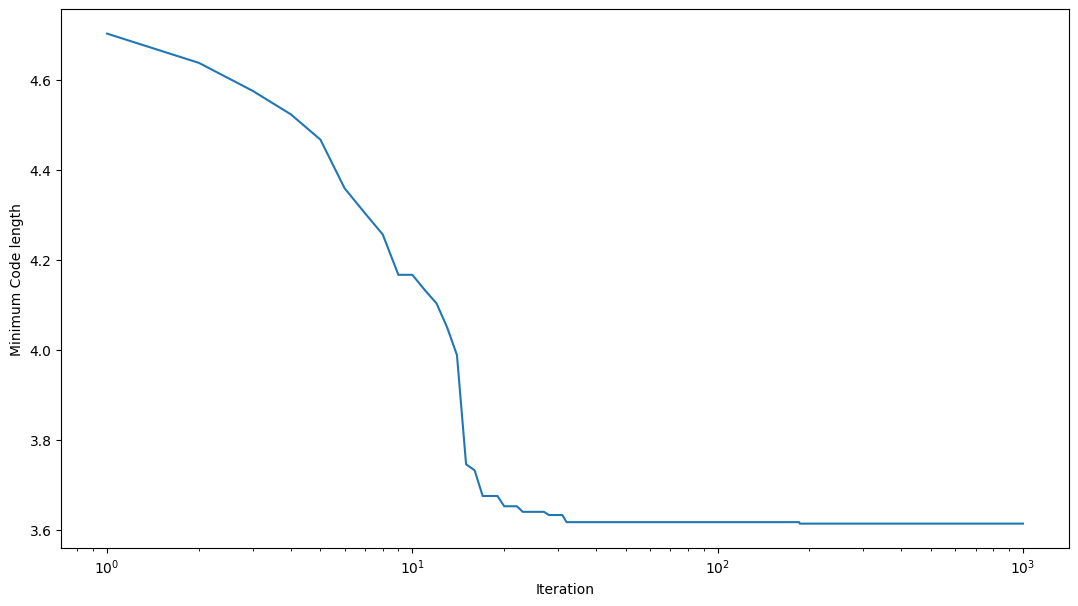

In [24]:
rw = pp.processes.RandomWalk(n_karate)
walk = []
for t, v in rw.simulation_run(steps=20000):
    walk.append(v[0])
C, dl = find_communities_walk(n_karate, walk, iterations=1000)

plt.figure(figsize=(13,7))
plt.semilogx([i for i in range(1,len(dl)+1)], dl)
plt.xlabel("Iteration")
plt.ylabel("Minimum Code length")
plt.show()

In [25]:
C

{0: 7,
 1: 7,
 2: 7,
 3: 7,
 4: 6,
 5: 5,
 6: 6,
 7: 7,
 8: 7,
 9: 7,
 10: 5,
 11: 11,
 12: 12,
 13: 7,
 14: 14,
 15: 15,
 16: 16,
 17: 7,
 18: 18,
 19: 19,
 20: 20,
 21: 7,
 22: 22,
 23: 7,
 24: 25,
 25: 25,
 26: 26,
 27: 25,
 28: 7,
 29: 26,
 30: 7,
 31: 7,
 32: 7,
 33: 7}

In [26]:
node_colors = []
for v in n_karate.nodes:
    node_colors.append(colors[C[v]])
pp.plot(n_karate, node_color = node_colors, edge_color='grey')


## Community Detection using the MapEquation

Above, we have applied Shannon's source coding theorem to a *specific* random walk sequence. Using the MapEquation, we can detect community structures that yield the minimum expected code length for *any* random walk. Let us implement this as explained in the lecture:

In [14]:
def MapEquation(g, C): 
    
    # create a mapping of communities to nodes
    community_to_nodes = defaultdict(list)
    for v in g.nodes:
        community_to_nodes[C[v]].append(v)
           

    # calculate number of nodes and edges
    m = g.M/2
    n = g.N
    
    # count number of edges across and within communities
    m_across = 0
        
    # sum of node degrees in each of the communities
    degree_community = defaultdict(lambda: 0)
    
    # iterate through the nodes to get probability to be in each community 
    for n in g.nodes:
        degree_community[C[n]]+=g.degrees()[n]

    # count number of edges that cross communities
    for e in g.edges:
        v = e[0]
        w = e[1]
        
        if C[v] != C[w]:
            m_across += 0.5
            
    # we can now calculate the MapEquation
    
    # first term: contribution of community switches to code length
    q = m_across/m
    #print('q = {0}'.format(q))    
    
    # entropy of community visitations
    H_Q = 0
    for c in degree_community:
        x = degree_community[c] / (2*m)
        H_Q += x * log2_0(x)
    # print('H_Q = {0}'.format(-H_Q))

    # second term: contribution of node changes to code length
    S = 0
    for c in community_to_nodes:
        #p_i = community_edges[c]/m
        H_Pi = 0
        p_i = degree_community[c] / (2*m)
        for node in community_to_nodes[c]:
            # Prob of single node within the community
            P_i = g.degrees()[node]/degree_community[c]
            # minimal code length 
            H_Pi  += -P_i * log2_0(P_i) 
        S += p_i * H_Pi

    return - q * H_Q + S

We apply this function to the toy example network from above and compare the minimal code length for the optimal node to cluster mapping with the minimum code length found by the function above. We recover the values given in the lecture:

In [15]:
m_true = {}
for i in range(16):
    m_true[str(i)] = i//4

m_underfit = {}
for i in range(16):
    m_underfit[str(i)] = i//8

m_overfit = {}
for i in range(16):
    m_overfit[str(i)] = i//2

m_flipped = {}
for i in range(16):
    m_flipped[str(i)] = i%4

In [16]:
MapEquation(g, m_true)

2.270942421748537

In [17]:
MapEquation(g, m_overfit)

3.1280852788913944

In [18]:
MapEquation(g, m_underfit)

3.0566567074628233

In [19]:
MapEquation(g, m_flipped)

3.9852281360342516

Using the heuristic optimisation algorithm from above, we finally write a function that returns the community structure with the minimal code length. We again start by assigning each node to its own community, iteratively merging pairs of communities, and keeping the new communities if the MapEquation for the new mapping yields a smaller code length. We test our method in the toy example from above and compare the minimum code length with the results from above:

In [24]:
def find_communities_ME(g, iterations=100):
    
    # start with each node being in a separate cluster
    C = { n:i for n ,i in zip(g.nodes,range(g.N)) }    
    
    dl = MapEquation(g, C)
    communities = set(C.values())
    edges = list(g.edges)
    dl_vals = [dl]
    for i in range(iterations):
        # randomly choose two communities
        e = edges[np.random.choice(len(edges))]
        x = C[e[0]]
        y = C[e[1]]
        # check description length of merged communities
        dl_new = MapEquation(g, merge(C,x,y))
        if dl_new < dl:
            # merge the communities
            C = merge(C,x,y)
            communities=set(C.values())
            dl = dl_new
            dl_vals.append(dl)
        else:
            dl_vals.append(dl)
    return C, dl_vals

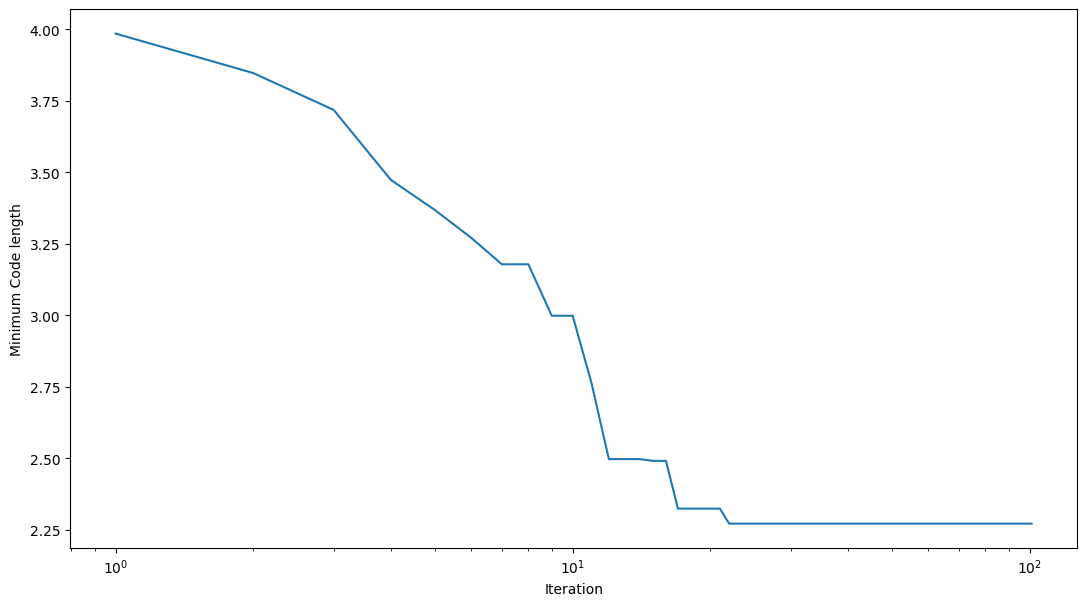

Minimum Code Length = 2.270942421748537 bits


In [25]:
min_code = np.inf
min_dl = None
min_C = None
for i in range(100):
    C, dl = find_communities_ME(g, iterations=100)
    if min(dl) < min_code:
        min_C = C
        min_code = min(dl)
        min_dl = dl

plt.figure(figsize=(13,7))
plt.semilogx([i for i in range(1,len(min_dl)+1)], min_dl)
plt.xlabel("Iteration")
plt.ylabel("Minimum Code length")
plt.show()
print('Minimum Code Length = {0} bits'.format(min(min_dl)))

In [32]:
node_colors = []

for v in g.nodes:
    node_colors.append(colors[min_C[v]])
pp.plot(g, node_color = node_colors)

We now use this method to find the optimal community structure in the karate club network. We return the detected number of communities and the minimum code length and visualise the optimal community structure.

In [35]:
min_code = np.inf
min_dl = None
min_C = None
for i in tqdm(range(10)):
    C, dl = find_communities_ME(n_karate, iterations=500)
    if min(dl) < min_code:
        min_C = C
        min_code = min(dl)
        min_dl = dl

/tmp/ipykernel_709/1326988505.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(10)):


  0%|          | 0/10 [00:00<?, ?it/s]

In [36]:
print(len(set(min_C.values())))
print('Minimum Code Length = {0} bits'.format(min(min_dl)))

9
Minimum Code Length = 3.3667367558450008 bits


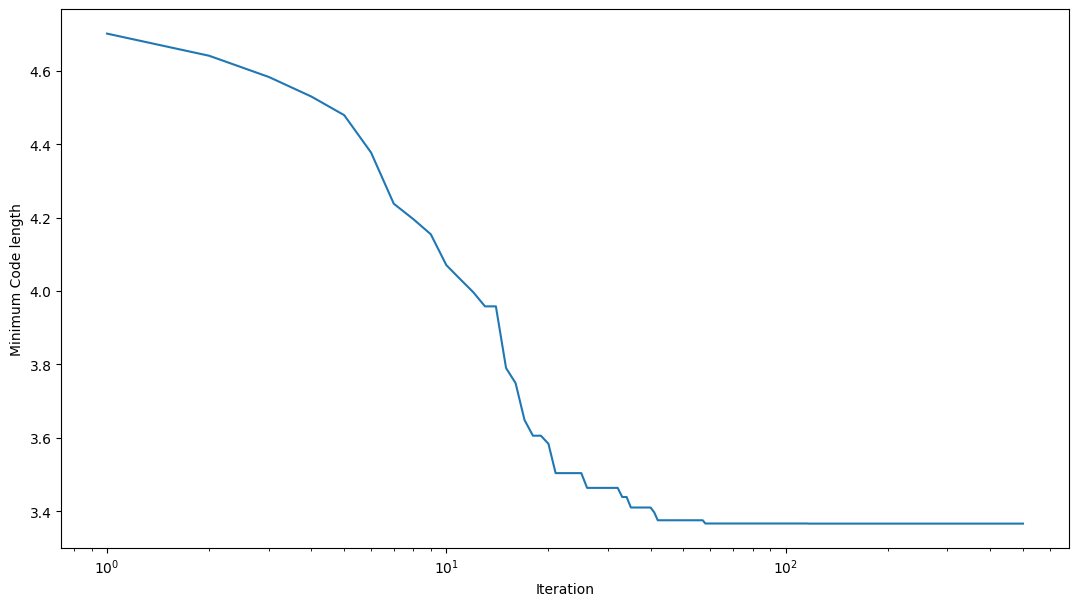

In [37]:
plt.figure(figsize=(13,7))
plt.semilogx([i for i in range(1,len(min_dl)+1)], min_dl)
plt.xlabel("Iteration")
plt.ylabel("Minimum Code length")
plt.show()


node_colors = []

for v in n_karate.nodes:
    node_colors.append(colors[min_C[v]])
pp.plot(n_karate, node_color = node_colors, edge_color='grey')
